## 1. 데이터 불러와 기본 변수 생성

In [1]:
import pandas as pd
df = pd.read_csv('C:/baf/final_data1102.csv')
print(df.head())

   Unnamed: 0  individual_id  curr_ann_amt  days_tenure date_of_birth  \
0           0   2.213000e+11    818.877997       1454.0    1978-06-23   
1           1   2.213001e+11    974.199182       1795.0    1950-05-30   
2           2   2.213007e+11    967.375112       4818.0    1967-07-07   
3           3   2.213016e+11    992.409561        130.0    1969-05-25   
4           4   2.213016e+11    784.633494       5896.0    1972-09-25   

     income  has_children  length_of_residence home_market_value  \
0   22500.0             1                 15.0     50000 - 74999   
1   27500.0             0                  2.0     50000 - 74999   
2   42500.0             0                 10.0     75000 - 99999   
3  125000.0             1                  6.0   175000 - 199999   
4   87500.0             1                  4.0   225000 - 249999   

   age_in_years  ...  dgs10_at_orig  cpi_at_orig  unrate_at_orig  \
0            44  ...       2.832632      252.767             3.9   
1            72 

In [2]:
# duration / event 정의
df["duration_years"] = df["days_tenure"] / 365.25
df["event"] = df["churn"].astype(int)
df["cust_orig_year"] = pd.to_datetime(df["cust_orig_month"]).dt.year

## 2. 사용변수 선택

In [6]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

selected_vars = [
    "tenure_years", "cpi_at_orig", "gdp_at_orig", "length_of_residence",
    "college_degree", "age_in_years", "has_children", "premium_to_income",
    "sp500_at_orig", "curr_ann_amt", "dgs10_at_orig", "age_at_orig",
    "home_owner", "unrate_at_orig", "good_credit"
]

# 실제 데이터에 존재하는 변수만 사용 (오타나 누락 방지)
X_cols = [c for c in selected_vars if c in df.columns]
print(X_cols)

['tenure_years', 'cpi_at_orig', 'gdp_at_orig', 'length_of_residence', 'college_degree', 'age_in_years', 'has_children', 'premium_to_income', 'sp500_at_orig', 'curr_ann_amt', 'dgs10_at_orig', 'age_at_orig', 'home_owner', 'unrate_at_orig', 'good_credit']


## 3. 시나리오 설정

In [4]:
# 가입연도 추출 -> Train/Test 분할
df["cust_orig_year"] = pd.to_datetime(df["cust_orig_month"]).dt.year

year_train = [2012,2013,2014, 2015, 2016]
year_test  = [2017, 2018]

train_df = df[df["cust_orig_year"].isin(year_train)]
test_df  = df[df["cust_orig_year"].isin(year_test)]

In [7]:
imp = SimpleImputer(strategy="median")
scl = StandardScaler()

X_train = pd.DataFrame(
    imp.fit_transform(train_df[X_cols]),
    columns=X_cols,
    index=train_df.index
)
X_test = pd.DataFrame(
    imp.transform(test_df[X_cols]),   # train 기준으로 transform만 수행
    columns=X_cols,
    index=test_df.index
)

X_train_std = pd.DataFrame(
    scl.fit_transform(X_train),       # fit은 train만
    columns=X_cols,
    index=train_df.index
)
X_test_std = pd.DataFrame(
    scl.transform(X_test),            # transform만
    columns=X_cols,
    index=test_df.index
)

In [8]:
## X_test 데이터 기초통계량들 확인
print(X_test_std.describe().T.head())

                        count      mean       std       min       25%  \
tenure_years         156334.0 -2.375415  0.401519 -3.059618 -2.726789   
cpi_at_orig          156334.0  3.414789  0.894558  2.179869  2.335041   
gdp_at_orig          156334.0  2.690900  0.632188  1.751818  1.921579   
length_of_residence  156334.0  0.014619  0.997007 -1.405663 -0.813552   
college_degree       156334.0  0.009293  1.003112 -0.716408 -0.716408   

                          50%       75%       max  
tenure_years        -2.382483 -1.996096 -1.665179  
cpi_at_orig          3.594226  4.229756  4.650204  
gdp_at_orig          2.874359  3.377753  3.505307  
length_of_residence -0.221441  0.962781  1.554892  
college_degree      -0.716408  1.395853  1.395853  


## 4. COX 생존분석모델학습

In [9]:
#Cox 모델 학습
train_for_cox = pd.concat(
    [train_df[["duration_years", "event"]], X_train_std], axis=1
)
test_for_cox = pd.concat(
    [test_df[["duration_years", "event"]], X_test_std], axis=1
)

cph = CoxPHFitter(penalizer=0.5, l1_ratio=0.0)
cph.fit(train_for_cox, duration_col="duration_years", event_col="event")

<lifelines.CoxPHFitter: fitted with 293275 total observations, 272731 right-censored observations>

In [12]:
ph = cph.predict_partial_hazard(test_for_cox).squeeze()
print(ph.nunique())
print(ph.describe())

156334
count    156334.000000
mean          3.654924
std           0.933376
min           2.235015
25%           2.643163
50%           3.883785
75%           4.621451
max           5.119725
dtype: float64


In [11]:
# 모델 평가
from lifelines.utils import concordance_index

train_pred = cph.predict_partial_hazard(train_for_cox)
test_pred  = cph.predict_partial_hazard(test_for_cox)

c_train = concordance_index(train_for_cox["duration_years"], -train_pred, train_for_cox["event"])
c_test  = concordance_index(test_for_cox["duration_years"], -test_pred, test_for_cox["event"])

print(f"{c_train:.3f} {c_test:.3f}")

0.979 0.947


결론 : 학습의 우위가 약간 있으나, 과적합은 아님
추가 확인 포인트

더 확실히 판단하려면 다음을 보면 좋아요:

1. Validation 세트 C-index (Train/Valid/Test 3개로 분리해 평가)

2. Penalizer 조정 (규제 강도)

penalizer 값을 5.0 → 10.0 정도로 늘려보면
overfitting이 있다면 Train은 약간 낮아지고 Test는 개선될 가능성 있음.

3. 변수 중요도 확인

cph.summary에서 exp(coef)가 매우 큰(>5) 변수가 많다면 일부 변수가 과도하게 영향을 줬을 수도 있음.

## 5. 결과 해석

In [13]:
summary = cph.summary.sort_values("p")
print(summary[["coef", "exp(coef)", "p"]])

                         coef  exp(coef)              p
covariate                                              
tenure_years        -0.098542   0.906158   0.000000e+00
cpi_at_orig          0.098057   1.103025   0.000000e+00
gdp_at_orig          0.096888   1.101737   0.000000e+00
sp500_at_orig        0.094938   1.099591  2.304342e-304
unrate_at_orig      -0.095242   0.909153  7.310083e-304
age_at_orig          0.007527   1.007555   2.205405e-03
curr_ann_amt         0.002558   1.002562   2.961046e-01
age_in_years        -0.002453   0.997550   3.182011e-01
dgs10_at_orig        0.001457   1.001458   5.574031e-01
college_degree      -0.001145   0.998856   6.397490e-01
good_credit         -0.000894   0.999107   7.151344e-01
has_children        -0.000605   0.999396   8.048414e-01
home_owner           0.000309   1.000309   8.995325e-01
premium_to_income   -0.000222   0.999778   9.278884e-01
length_of_residence  0.000206   1.000206   9.330689e-01


In [14]:
import numpy as np
import pandas as pd

# 예측 시점 설정 (년 단위)
time_grid = np.linspace(0, 20, 400)  
years_to_predict = [1, 3, 5, 10, 20]

# 테스트 데이터셋의 각 고객별 생존확률 예측
S_mat = cph.predict_survival_function(test_for_cox, times=time_grid)

# 고객별 해지확률 계산 (1 - 생존확률)
pred_df = pd.DataFrame()
pred_df["individual_id"] = test_df["individual_id"].values  

for yr in years_to_predict:
    idx = np.abs(time_grid - yr).argmin()  # 해당 연도에 가장 가까운 인덱스
    churn_prob = 1 - S_mat.iloc[idx, :].values  # 해지확률 = 1 - 생존확률
    pred_df[f"churn_prob_{yr}yr"] = churn_prob

# 결과 확인
print(pred_df.head())

   individual_id  churn_prob_1yr  churn_prob_3yr  churn_prob_5yr  \
0   2.213000e+11        0.000070        0.000070        0.000070   
1   2.213001e+11        0.000061        0.000061        0.000061   
2   2.213029e+11        0.000036        0.000036        0.000036   
3   2.213008e+11        0.000043        0.000043        0.000043   
4   2.213002e+11        0.000060        0.000060        0.000060   

   churn_prob_10yr  churn_prob_20yr  
0         0.621669         0.997441  
1         0.568911         0.994296  
2         0.395891         0.954709  
3         0.449559         0.974419  
4         0.561664         0.993681  


In [15]:
coef_abs = cph.summary["coef"].abs() #2
print(coef_abs.sum())
print(cph.summary[["coef","exp(coef)","p"]].sort_values("p").head(10))


0.5010423930639861
                    coef  exp(coef)              p
covariate                                         
tenure_years   -0.098542   0.906158   0.000000e+00
cpi_at_orig     0.098057   1.103025   0.000000e+00
gdp_at_orig     0.096888   1.101737   0.000000e+00
sp500_at_orig   0.094938   1.099591  2.304342e-304
unrate_at_orig -0.095242   0.909153  7.310083e-304
age_at_orig     0.007527   1.007555   2.205405e-03
curr_ann_amt    0.002558   1.002562   2.961046e-01
age_in_years   -0.002453   0.997550   3.182011e-01
dgs10_at_orig   0.001457   1.001458   5.574031e-01
college_degree -0.001145   0.998856   6.397490e-01


<Axes: title={'center': '평균 생존곡선'}>

C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\U

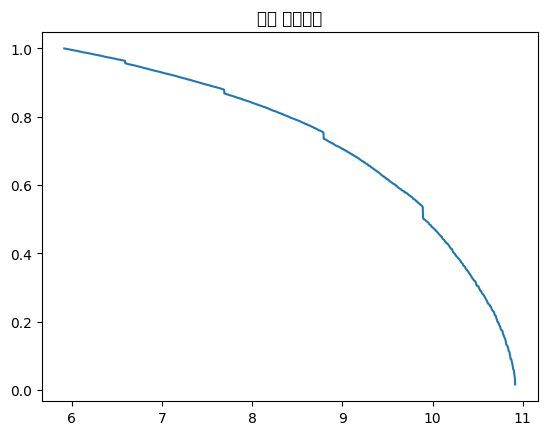

In [16]:
S_avg = cph.predict_survival_function(test_for_cox).mean(axis=1)
S_avg.plot(title="평균 생존곡선")

In [17]:
import numpy as np
import pandas as pd

# 예측할 시점 설정 (1년, 3년, 5년, 10년 등)
time_grid = np.linspace(0, 20, 400)
years_to_predict = [1, 3, 5, 10]

# 생존확률 예측
S_mat = cph.predict_survival_function(test_for_cox, times=time_grid)

# 각 고객별 해지확률 계산
pred_df = pd.DataFrame()
pred_df["individual_id"] = test_df["individual_id"].values  

for yr in years_to_predict:
    idx = np.abs(time_grid - yr).argmin()
    churn_prob = 1 - S_mat.iloc[idx, :].values  # 해지확률 = 1 - 생존확률
    pred_df[f"churn_prob_{yr}yr"] = churn_prob

# 결과 확인
print(pred_df.head(10))

   individual_id  churn_prob_1yr  churn_prob_3yr  churn_prob_5yr  \
0   2.213000e+11        0.000070        0.000070        0.000070   
1   2.213001e+11        0.000061        0.000061        0.000061   
2   2.213029e+11        0.000036        0.000036        0.000036   
3   2.213008e+11        0.000043        0.000043        0.000043   
4   2.213002e+11        0.000060        0.000060        0.000060   
5   2.213017e+11        0.000070        0.000070        0.000070   
6   2.213023e+11        0.000040        0.000040        0.000040   
7   2.213000e+11        0.000051        0.000051        0.000051   
8   2.213028e+11        0.000074        0.000074        0.000074   
9   2.213010e+11        0.000039        0.000039        0.000039   

   churn_prob_10yr  
0         0.621669  
1         0.568911  
2         0.395891  
3         0.449559  
4         0.561664  
5         0.621887  
6         0.426185  
7         0.508243  
8         0.642307  
9         0.412995  


In [20]:
output_path = "C:/baf/cox_pred_5yr_customers.csv"
pred_df.to_csv(output_path, index=False, encoding='utf-8-sig')

## 참고
##### 규제강도 최적화

   penalizer  C_train  C_test  hazard_std  hazard_min  hazard_max
0       0.05   0.9847  0.9535    521.4480     42.6181   1688.0619
1       0.10   0.9832  0.9506     42.5361     12.0564    144.2851
2       0.20   0.9815  0.9481      6.3368      4.8953     24.4853
3       0.50   0.9789  0.9467      0.9334      2.2350      5.1197
4       1.00   0.9775  0.9464      0.3003      1.5663      2.4960
5       2.00   0.9767  0.9463      0.1161      1.2702      1.6300


C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 5

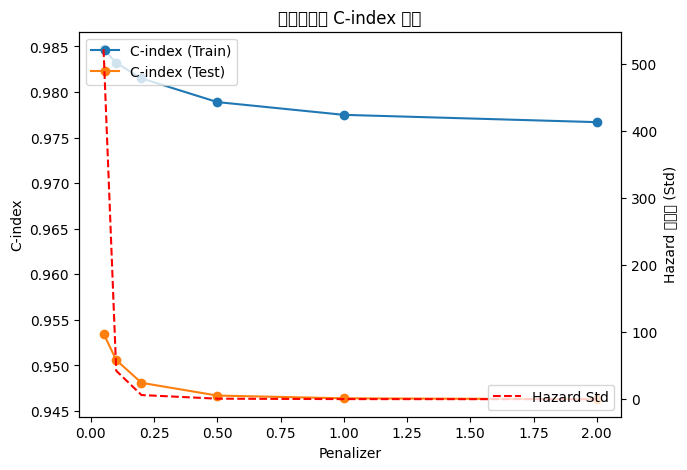

In [19]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

penalizer_values = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
results = []

for p in penalizer_values:
    cph = CoxPHFitter(penalizer=p, l1_ratio=0.0)
    cph.fit(train_for_cox, duration_col="duration_years", event_col="event")

    # Concordance Index 계산
    train_pred = cph.predict_partial_hazard(train_for_cox)
    test_pred  = cph.predict_partial_hazard(test_for_cox)
    c_train = concordance_index(train_for_cox["duration_years"], -train_pred, train_for_cox["event"])
    c_test  = concordance_index(test_for_cox["duration_years"], -test_pred, test_for_cox["event"])

    # partial hazard 다양성 확인 (test 기준)
    ph = cph.predict_partial_hazard(test_for_cox).squeeze()
    hazard_std = ph.std()
    hazard_min, hazard_max = ph.min(), ph.max()

    results.append({
        "penalizer": p,
        "C_train": round(c_train, 4),
        "C_test": round(c_test, 4),
        "hazard_std": round(hazard_std, 4),
        "hazard_min": round(hazard_min, 4),
        "hazard_max": round(hazard_max, 4)
    })

# 결과 요약
result_df = pd.DataFrame(results)
print(result_df)

# 규제강도별 성능 그래프
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.plot(result_df["penalizer"], result_df["C_train"], marker="o", label="C-index (Train)")
ax1.plot(result_df["penalizer"], result_df["C_test"], marker="o", label="C-index (Test)")
ax1.set_xlabel("Penalizer")
ax1.set_ylabel("C-index")
ax1.legend(loc="upper left")
ax1.set_title("규제강도별 C-index 변화")

ax2 = ax1.twinx()
ax2.plot(result_df["penalizer"], result_df["hazard_std"], color="red", linestyle="--", label="Hazard Std")
ax2.set_ylabel("Hazard 다양성 (Std)")
ax2.legend(loc="lower right")

plt.show()
# 0.5 로 설정

#### 해석

##### train과 test의 차이가 너무 크지않고, hazard_std가 0.8~7에 형성되어있음

In [21]:
import numpy as np
import pandas as pd

# 예측할 시점 설정
times = [1, 3, 5, 10]

# 예측 생존확률 계산
S_pred = cph.predict_survival_function(test_for_cox, times=times).T  # (개인 × 시간)

# β의 공분산 행렬
var_beta = cph.variance_matrix_

# 신뢰구간 계산 (Delta Method)
X = test_for_cox[cph.params_.index].values
z = 1.96  # 95% CI 기준

ci_list = []

for t_idx, t in enumerate(times):
    # 시간별 생존확률
    S_t = S_pred.iloc[:, t_idx].values

    # log(S(t))의 분산 근사
    var_logS = np.sum((X @ var_beta.values) * X, axis=1)
    se_logS = np.sqrt(var_logS)

    # 신뢰구간 계산
    lower = np.exp(np.log(S_t) - z * se_logS)
    upper = np.exp(np.log(S_t) + z * se_logS)

    ci_df = pd.DataFrame({
        "individual_id": test_df["individual_id"],
        f"S_{t}yr": S_t,
        f"S_{t}yr_lower": lower,
        f"S_{t}yr_upper": upper
    })
    ci_list.append(ci_df)

# 모든 기간 결과 병합
ci_all = ci_list[0]
for i in range(1, len(ci_list)):
    ci_all = ci_all.merge(ci_list[i], on="individual_id", how="left")

# 생존확률 → 해지확률 변환
for t in times:
    ci_all[f"churn_{t}yr"] = 1 - ci_all[f"S_{t}yr"]
    ci_all[f"churn_{t}yr_lower"] = 1 - ci_all[f"S_{t}yr_upper"]
    ci_all[f"churn_{t}yr_upper"] = 1 - ci_all[f"S_{t}yr_lower"]

# 결과 확인
print(ci_all.head())

# CSV로 저장
output_path = "C:/baf/cox_pred_ci_1_3_5_10yr.csv"
ci_all.to_csv(output_path, index=False, encoding="utf-8-sig")

   individual_id     S_1yr  S_1yr_lower  S_1yr_upper     S_3yr  S_3yr_lower  \
0   2.213000e+11  0.999973     0.980359     1.019980  0.999973     0.980359   
1   2.213001e+11  0.999975     0.981439     1.018861  0.999975     0.981439   
2   2.213029e+11  0.999978     0.988736     1.011348  0.999978     0.988736   
3   2.213008e+11  0.999977     0.986224     1.013921  0.999977     0.986224   
4   2.213002e+11  0.999975     0.981481     1.018816  0.999975     0.981481   

   S_3yr_upper     S_5yr  S_5yr_lower  S_5yr_upper  ...  churn_1yr_upper  \
0     1.019980  0.999973     0.980359     1.019980  ...         0.019641   
1     1.018861  0.999975     0.981439     1.018861  ...         0.018561   
2     1.011348  0.999978     0.988736     1.011348  ...         0.011264   
3     1.013921  0.999977     0.986224     1.013921  ...         0.013776   
4     1.018816  0.999975     0.981481     1.018816  ...         0.018519   

   churn_3yr  churn_3yr_lower  churn_3yr_upper  churn_5yr  churn_5yr

In [22]:
(df["duration_years"] > 5).sum(), df.loc[df["duration_years"] > 5, "event"].sum()

(np.int64(1146706), np.int64(80348))